In [ ]:
!pip install qiskit qiskit-aer matplotlib numpy pandas

In [ ]:
!pip install pylatexenc

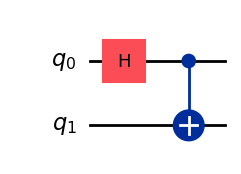

In [ ]:
from qiskit import QuantumCircuit
def build_bell_circuit():
    qc=QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return qc

qc = build_bell_circuit()
qc.draw('mpl')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from numpy.polynomial import Polynomial

from qiskit import QuantumCircuit
from qiskit.quantum_info import state_fidelity, Statevector


from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

os.makedirs("results", exist_ok=True)

print("Ready. Qiskit version:", __import__('qiskit').__version__)

Ready. Qiskit version: 2.2.3


In [ ]:
base_depol = 0.01
scale_factors = [1.0, 2.0, 3.0]
seeds = [101, 102, 103, 104, 105]
readout_prob = 0.0
num_shots = 0

print("ZNE config:", "base_depol=", base_depol, "scales=", scale_factors, "seeds=", seeds)

ZNE config: base_depol= 0.01 scales= [1.0, 2.0, 3.0] seeds= [101, 102, 103, 104, 105]


In [ ]:
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.quantum_info import Statevector, state_fidelity



def noise_model_depolarizing(depol_prob=0.0, readout_error_prob=0.0):
    nm = NoiseModel()

    dep_err = depolarizing_error(depol_prob, 1)
    dep_err2 = depolarizing_error(depol_prob, 2)

    nm.add_all_qubit_quantum_error(dep_err, ["u1", "u2", "u3"])
    nm.add_all_qubit_quantum_error(dep_err2, ["cx"])

    if readout_error_prob > 0:
        ro_err = ReadoutError([[1 - readout_error_prob, readout_error_prob],
                               [readout_error_prob, 1 - readout_error_prob]])
        nm.add_all_qubit_readout_error(ro_err)

    return nm



def run_statevector_sim(qc, noise_model=None, seed_sim=1234):
    backend = AerSimulator(
        method="density_matrix",
        seed_simulator=seed_sim,
        noise_model=noise_model
    )

    qc2 = qc.copy()
    qc2.save_density_matrix()

    result = backend.run(qc2).result()
    return result.data(0)['density_matrix']



def run_zne(qc, base_depol, scales, seeds, readout_prob=0.0):


    ideal_state = run_statevector_sim(qc, noise_model=None, seed_sim=999)

    rows = []

    for scale in scales:
        depol = base_depol * scale
        fidelities = []

        for s in seeds:
            nm = noise_model_depolarizing(depol_prob=depol, readout_error_prob=readout_prob)
            sv = run_statevector_sim(qc, noise_model=nm, seed_sim=s)
            f = state_fidelity(ideal_state, sv)
            fidelities.append(f)

        rows.append({
            "scale": scale,
            "depol_prob": depol,
            "readout_prob": readout_prob,
            "fidelity_mean": float(np.mean(fidelities)),
            "fidelity_std": float(np.std(fidelities)),
            "num_seeds": len(seeds),
            "raw_fidelities": fidelities
        })

    return pd.DataFrame(rows)


qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

base_depol = 0.01
scales = [1, 2, 3, 4, 5]
seeds = [1001, 1002, 1003, 1004, 1005]

df_zne = run_zne(qc, base_depol, scales, seeds, readout_prob=0.0)
print(df_zne)

df_zne.to_csv("exp2_zne_summary.csv", index=False)


   scale  depol_prob  readout_prob  fidelity_mean  fidelity_std  num_seeds  \
0      1        0.01           0.0         0.9925  0.000000e+00          5   
1      2        0.02           0.0         0.9850  1.110223e-16          5   
2      3        0.03           0.0         0.9775  1.110223e-16          5   
3      4        0.04           0.0         0.9700  1.110223e-16          5   
4      5        0.05           0.0         0.9625  0.000000e+00          5   

                                      raw_fidelities  
0  [0.9924999999999994, 0.9924999999999994, 0.992...  
1  [0.9849999999999999, 0.9849999999999999, 0.984...  
2  [0.9775000000000001, 0.9775000000000001, 0.977...  
3  [0.9700000000000011, 0.9700000000000011, 0.970...  
4  [0.9625000000000001, 0.9625000000000001, 0.962...  


In [ ]:
from scipy import stats
from numpy.polynomial import Polynomial
x = df_zne['scale'].to_numpy()
y = df_zne['fidelity_mean'].to_numpy()

coefs = Polynomial.fit(x, y, deg=2).convert().coef
p = Polynomial(coefs)
extrap_poly_0 = float(p(0.0))


slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
extrap_richardson_0 = float(intercept)

print("Poly coeffs (c0,c1,c2):", coefs)
print("Poly-extrapolated fidelity @scale=0 :", extrap_poly_0)
print("Linear Richardson extrapolated fidelity @scale=0 :", extrap_richardson_0)
print("Linear fit R^2:", r_value**2)

df_plot = df_zne.copy()
df_plot['poly_fit'] = [float(p(xx)) for xx in x]
df_plot.to_csv("results/exp2_zne_summary_with_fit.csv", index=False)


Poly coeffs (c0,c1,c2): [ 1.00000000e+00 -7.50000000e-03 -1.36851206e-16]
Poly-extrapolated fidelity @scale=0 : 0.9999999999999983
Linear Richardson extrapolated fidelity @scale=0 : 0.9999999999999992
Linear fit R^2: 0.9999999999999998


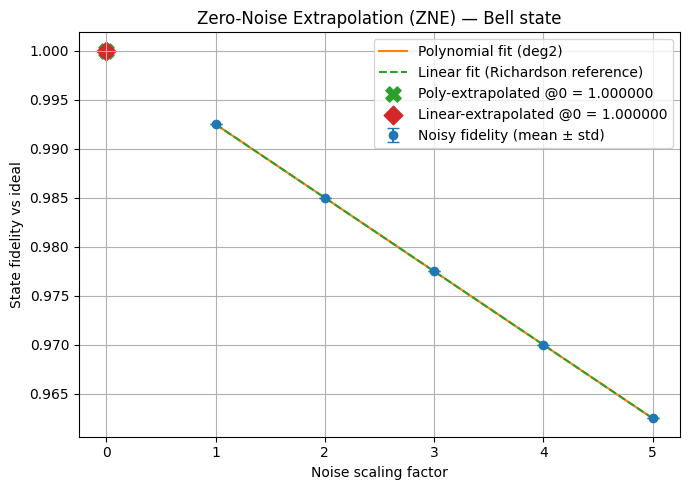

In [ ]:
import matplotlib.pyplot as plt
x_fine = np.linspace(min(x), max(x), 200)
y_poly = [float(p(xx)) for xx in x_fine]

plt.figure(figsize=(7,5))
plt.errorbar(x, y, yerr=df_zne['fidelity_std'], fmt='o', label='Noisy fidelity (mean ± std)', capsize=4)
plt.plot(x_fine, y_poly, '-', label='Polynomial fit (deg2)')
y_lin = intercept + slope * x_fine
plt.plot(x_fine, y_lin, '--', label='Linear fit (Richardson reference)')

plt.scatter([0.0], [extrap_poly_0], marker='X', s=120, color='C2', label=f'Poly-extrapolated @0 = {extrap_poly_0:.6f}')
plt.scatter([0.0], [extrap_richardson_0], marker='D', s=90, color='C3', label=f'Linear-extrapolated @0 = {extrap_richardson_0:.6f}')

plt.xlabel("Noise scaling factor")
plt.ylabel("State fidelity vs ideal")
plt.title("Zero-Noise Extrapolation (ZNE) — Bell state")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/exp2_zne_plot.png", dpi=300)
plt.show()